In [2]:
import numpy as np
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import ast 

df=pd.read_csv("../datasets/manufacturing_quality_mixed_scalar_interval.csv",delimiter=",")
df=df.iloc[:,1:]
df.head(10)

,temperature,Quality
0,184.0,[3.86]
1,244.0,"[4.0, 6.0]"
2,100.0,"[0.0, 3.0]"
3,160.0,"[2.0, 4.0]"
4,130.0,"[2.0, 4.0]"
5,118.0,"[1.0, 4.0]"
6,138.0,"[1.0, 4.0]"
7,170.0,"[1.0, 4.0]"
8,180.0,"[2.0, 5.0]"
9,208.0,"[2.0, 6.0]"


Note that the first quality measurement is a scalar, while the second is an interval.

In [3]:
Y=[]
for i in range(len(df.iloc[:,1])):
    Y.append(ast.literal_eval(df.iloc[i,1]))
temperatures=df.iloc[:,0].values
sizes=[len(d) for d in Y]
sizes=np.array(sizes)

tn=temperatures[sizes==1]#temperatures for the scalar observations
ti=temperatures[sizes==2]#temperatures for the interval observations

yn=np.vstack(np.array(Y)[sizes==1])#scalar observations
Yi=np.vstack(np.array(Y)[sizes==2])#interval observations
yl=Yi[:,0]#lower
yu=Yi[:,1]#upper

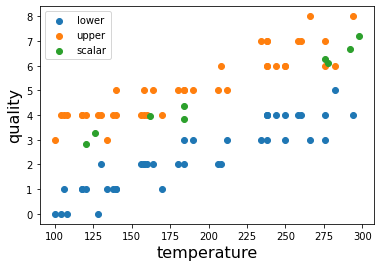

In [4]:
plt.scatter(ti,yl, color='C0' ,label='lower')
plt.scatter(ti,yu, color='C1'  ,label='upper')
plt.scatter(tn,yn, color='C2'  ,label='scalar')
plt.legend()
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16);

In [5]:
import theano.tensor as tt

def custom_dist_logp(mu,sigma,yl,yu):
    return pm.Bernoulli.dist(0.5*tt.erfc(-(yu-mu)/sigma/np.sqrt(2))).logp(1.0)+pm.Bernoulli.dist(0.5*tt.erfc((yl-mu)/sigma/np.sqrt(2))).logp(1.0)


mymodel=pm.Model()
with mymodel:
    alpha = pm.Normal('alpha',0.0,30)
    beta  = pm.Normal('beta', 0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    mu1=alpha+beta*ti
    mu2=alpha+beta*tn
    l1=pm.DensityDist('Like1',custom_dist_logp,observed=dict(mu=mu1, sigma=sigma, yl=yl, yu=yu))
    l2=pm.Normal('Like2', mu2, sigma, observed=yn[:,0])

with mymodel:
    posterior_samples=pm.sample(5000,tune=1000,chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 0, 4 divergences: 100%|██████████| 6000/6000 [00:12<00:00, 490.97it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


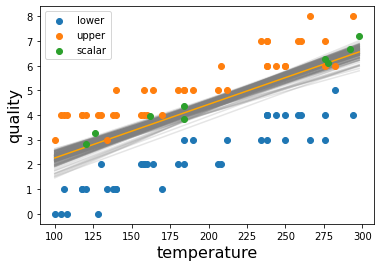

In [8]:
xx=np.linspace(np.min(np.hstack([ti,tn])),np.max(np.hstack([ti,tn])))
for i in range(200):
    plt.plot(xx,xx*posterior_samples['beta'][i]+posterior_samples['alpha'][i],c='gray',alpha=0.2)#regression line
plt.plot(xx,xx*posterior_samples['beta'].mean()+posterior_samples['alpha'].mean(),c='orange')

plt.scatter(ti,yl, color='C0' ,label='lower',zorder=100)
plt.scatter(ti,yu, color='C1'  ,label='upper',zorder=100)
plt.scatter(tn,yn, color='C2'  ,label='scalar',zorder=100)
plt.legend()
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16);
plt.savefig("solution_problem_mixed1.png")

Probability that quality is greater than 7.2= 0.198


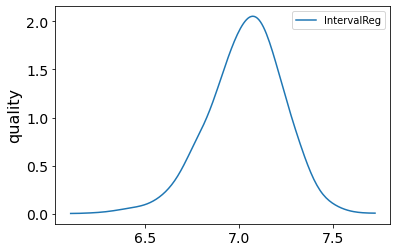

In [9]:
az.plot_dist(320*posterior_samples['beta']+posterior_samples['alpha'],label='IntervalReg')

Prob = len(np.where(320*posterior_samples['beta']+posterior_samples['alpha']>7.2)[0])/len(posterior_samples['beta'])
print("Probability that quality is greater than 7.2=",Prob)
plt.ylabel("quality",fontsize=16)
plt.savefig("solution_problem_mixed2.png")